<a href="https://colab.research.google.com/github/christpaul94/MastersThesis_PaulChrist/blob/main/TrappedAtomsSimulation_DeltaKickCooling_HarmonicPotential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\# TrappedAtomsSimulation_HarmonicPotential

Author: Paul Christ

Date: 04.11.2025


In [1]:
!pip install -qq git+https://github.com/christpaul94/MastersThesis_PaulChrist.git

  Preparing metadata (setup.py) ... done


In [2]:
# Import
from TrappedAtomsSimulation.initialization import initialize_one_temp_gaussian_state, initialize_two_temp_gaussian_state
from TrappedAtomsSimulation.force_calculation import calculate_interaction_strength
from TrappedAtomsSimulation.force_calculation import pair_keops_fp
from TrappedAtomsSimulation.integrators import run_verlet_simulation_HO, solve_harmonic_analytical, run_verlet_simulation_general, harmonic_fp, no_force_fp, no_pair_force_fp
from TrappedAtomsSimulation.plot_utils import plot_energy_and_error, plot_thermalization, plot_temperature_evolution

import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

## Trap

In [4]:
trap_frequencies_Hz = (1000.0, 1000.0, 1000.0)


# DKC

Interaktionsparameter: r0=5.24e-08, C=2.24e-30
Starte Phase 1: Fangen...
--- Skalierung basierend auf T = 1.00e-08 K ---
Längenskala L0: 1.56e-07 m, Energieskala E0: 1.38e-31 J, Zeitskala T0: 1.59e-04 s
Initialisiere 100000 Teilchen bei T = 1.00e-08 K
--- Initialisierung abgeschlossen ---

Integration 100% | ETA: 0 min 0 s
Integration abgeschlossen.
Phase 1 abgeschlossen.
Starte Phase 2: Freie Expansion...
--- Skalierung basierend auf T = 1.00e-08 K ---
Längenskala L0: 1.56e-07 m, Energieskala E0: 1.38e-31 J, Zeitskala T0: 1.59e-04 s
Initialisiere 100000 Teilchen bei T = 1.00e-08 K
--- Initialisierung abgeschlossen ---

Integration 100% | ETA: 0 min 0 s
Integration abgeschlossen.
Phase 2 abgeschlossen.
Starte Phase 3: Delta-Kick...
--- Skalierung basierend auf T = 1.00e-08 K ---
Längenskala L0: 9.83e-08 m, Energieskala E0: 1.38e-31 J, Zeitskala T0: 1.01e-04 s
Initialisiere 100000 Teilchen bei T = 1.00e-08 K
--- Initialisierung abgeschlossen ---

Integration 100% | ETA: 0 min 0 s
Integr

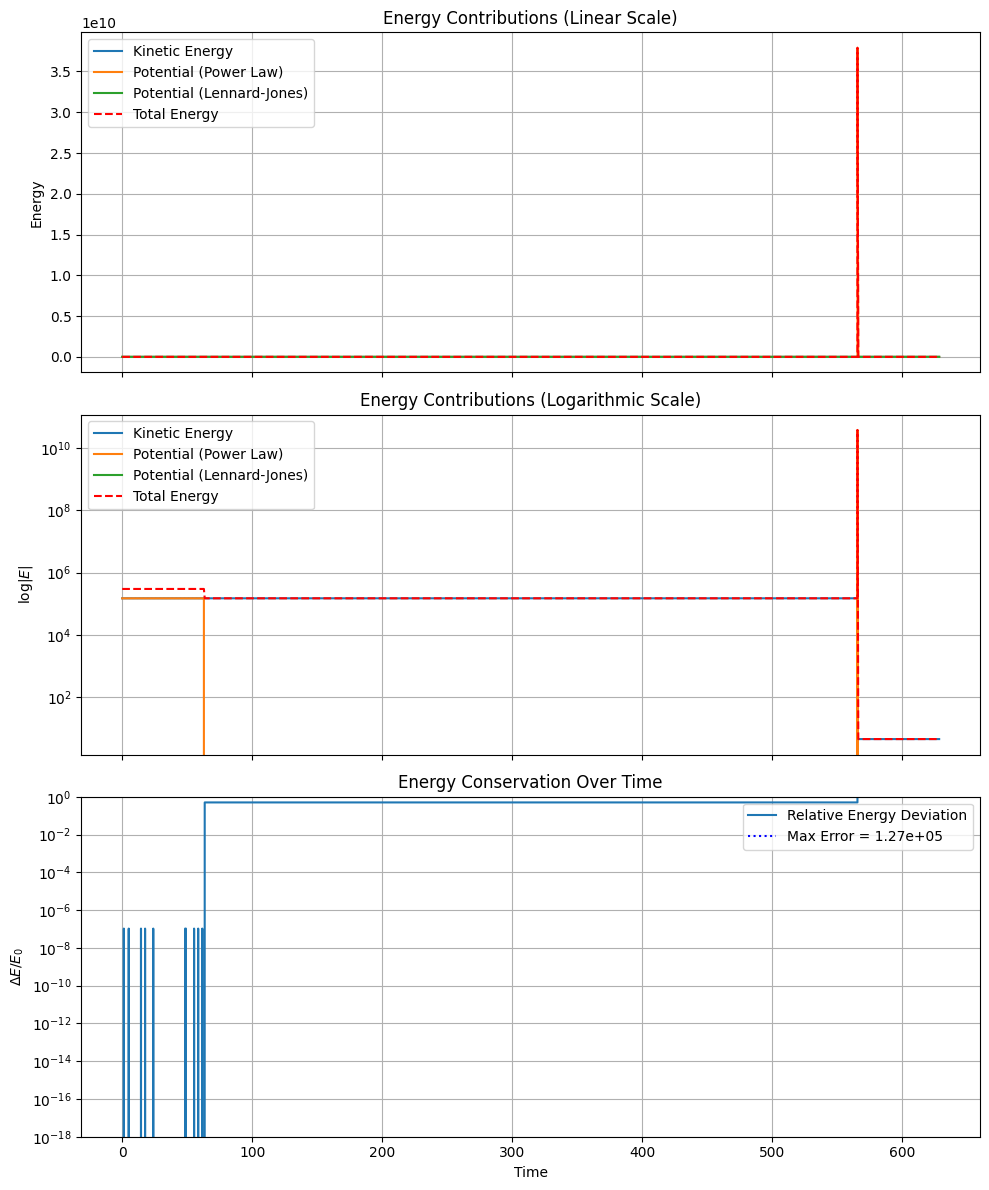


Erstelle kombinierten Temperatur-Plot...


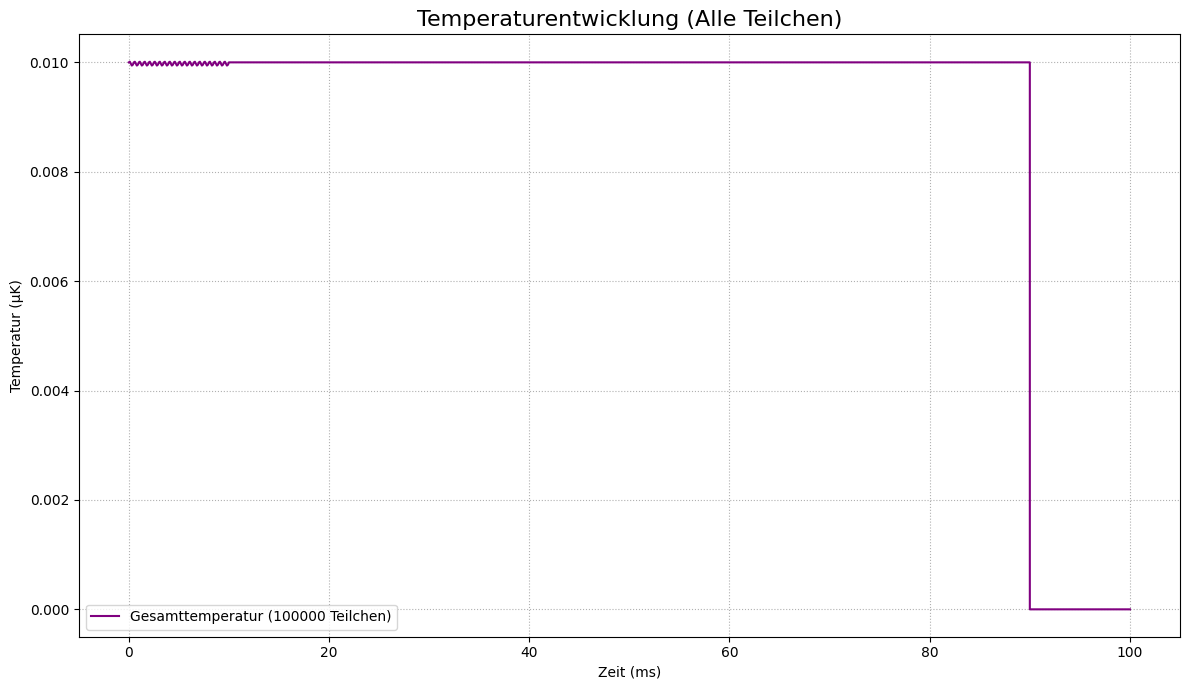

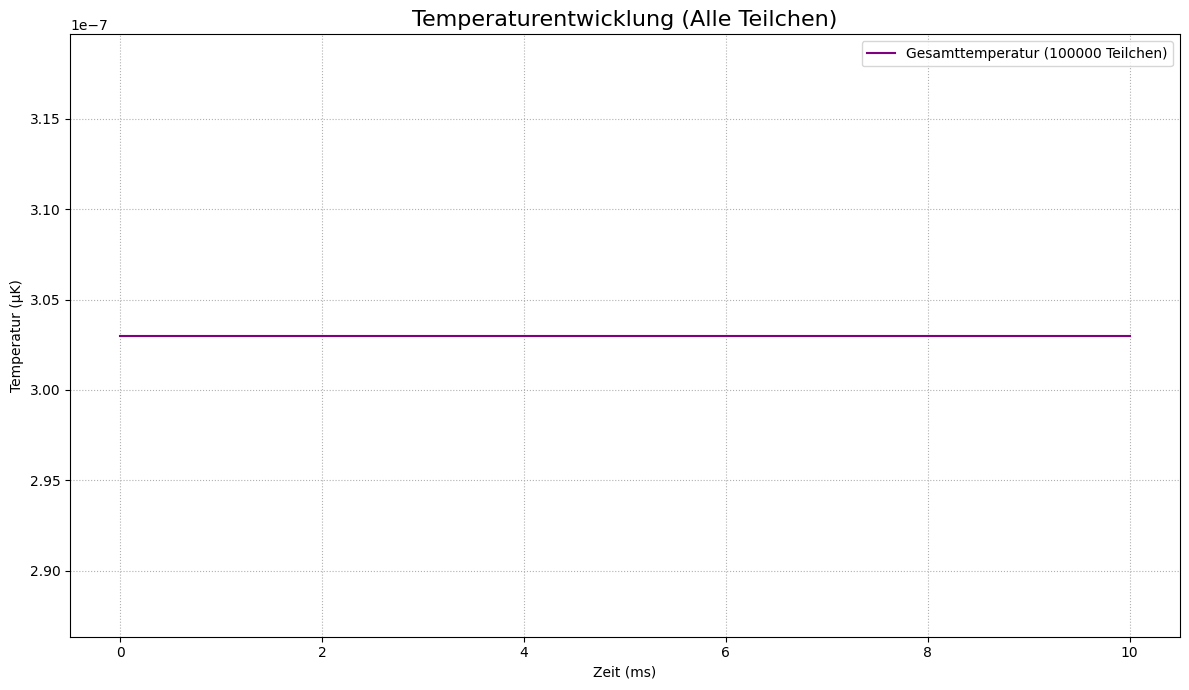

In [5]:
# --- PARAMETER ---
timestep_s = 1e-4
substeps = 100
n_particles = 100000
T = 1e-8

# --- Simulationszeiten ---
simulation_time_s__phase1 = 0.01  # 10 ms (Fangen)
simulation_time_s__phase2 = 0.08  # 50 ms (Freie Expansion 1)
simulation_time_s__phase3 = 200e-9 # 200 ns (Kick)
simulation_time_s__phase4 = 0.01  # 10 ms (Freie Expansion 2 zur Beobachtung)


r0_phys,C_phys = calculate_interaction_strength(10)
print(f"Interaktionsparameter: r0={r0_phys:.2e}, C={C_phys:.2e}")

# ===================================================================
# --- ERSTER SCHRITT: FALLE AN (Phase 1) ---
# ===================================================================
print("Starte Phase 1: Fangen...")
initial_state_params_phase1 = initialize_one_temp_gaussian_state(
    n_particles=n_particles, temp_k=T, omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s__phase1, dt_s=timestep_s,
    r0_phys=r0_phys, C_phys=C_phys, precision=dtype, device=device
)
trap_params_dict_phase1 = {
    "omega_matrix": initial_state_params_phase1['omega_matrix']
}
integrator_config_phase1 = {
    "trap_force_func": harmonic_fp,
    "trap_force_params": trap_params_dict_phase1,
    "pair_force_func": no_pair_force_fp, "substeps": substeps
}
simulation_input_args_phase1 = {**initial_state_params_phase1, **integrator_config_phase1}
simulation_results_phase1 = run_verlet_simulation_general(**simulation_input_args_phase1, silent=False) # Silent-Modus
print("Phase 1 abgeschlossen.")

# ===================================================================
# --- ZWEITER SCHRITT: FREIE EXPANSION (Phase 2) ---
# ===================================================================
print("Starte Phase 2: Freie Expansion...")
initial_state_params_phase2 = initialize_one_temp_gaussian_state(
    n_particles=n_particles, temp_k=T, omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s__phase2, dt_s=timestep_s,
    r0_phys=r0_phys, C_phys=C_phys, precision=dtype, device=device
)
initial_state_params_phase2['q0'] = simulation_results_phase1['positions'][-1]
initial_state_params_phase2['p0'] = simulation_results_phase1['momenta'][-1]
integrator_config_phase2 = {
    "trap_force_func": no_force_fp, "trap_force_params": {},
    "pair_force_func": no_pair_force_fp, "substeps": substeps
}
simulation_input_args_phase2 = {**initial_state_params_phase2, **integrator_config_phase2}
simulation_input_args_phase2.pop('omega_matrix', None)
simulation_results_phase2 = run_verlet_simulation_general(**simulation_input_args_phase2, silent=False)
print("Phase 2 abgeschlossen.")

# ===================================================================
# --- DRITTER SCHRITT: DELTA-KICK (Phase 3) ---
# ===================================================================
print("Starte Phase 3: Delta-Kick...")
timestep_s_phase3 = 1e-9 # Nur ein Schritt für den Kick
trap_frequencies_Hz_kick = (1583.0, 1583.0, 1583.0)
initial_state_params_phase3 = initialize_one_temp_gaussian_state(
    n_particles=n_particles, temp_k=T, omega_phys_hz=trap_frequencies_Hz_kick,
    t_end_s=simulation_time_s__phase3, dt_s=timestep_s_phase3, # Zeitachse für Phase 3
    r0_phys=r0_phys, C_phys=C_phys, precision=dtype, device=device
)
initial_state_params_phase3['q0'] = simulation_results_phase2['positions'][-1]
initial_state_params_phase3['p0'] = simulation_results_phase2['momenta'][-1]
trap_params_dict_phase3 = {
    "omega_matrix": initial_state_params_phase3['omega_matrix'] # Ursprüngliche Matrix
}
integrator_config_phase3 = {
    "trap_force_func": harmonic_fp,
    "trap_force_params": trap_params_dict_phase3,
    "pair_force_func": no_pair_force_fp, "substeps": substeps
}
simulation_input_args_phase3 = {**initial_state_params_phase3, **integrator_config_phase3}
simulation_results_phase3 = run_verlet_simulation_general(**simulation_input_args_phase3, silent=False)
print("Phase 3 (Kick) abgeschlossen.")

# ===================================================================
# --- NEU: VIERTER SCHRITT: BEOBACHTUNG (Phase 4) ---
# ===================================================================
print("Starte Phase 4: Beobachtung (Freie Expansion)...")
initial_state_params_phase4 = initialize_one_temp_gaussian_state(
    n_particles=n_particles, temp_k=T, omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s__phase4, dt_s=timestep_s, # Normale Schrittweite
    r0_phys=r0_phys, C_phys=C_phys, precision=dtype, device=device
)
# Start von Phase 4 ist das Ende von Phase 3
initial_state_params_phase4['q0'] = simulation_results_phase3['positions'][-1]
initial_state_params_phase4['p0'] = simulation_results_phase3['momenta'][-1]

trap_params_dict_phase4 = {
    "omega_matrix": initial_state_params_phase1['omega_matrix'] # Ursprüngliche Matrix
}
integrator_config_phase4 = {
    "trap_force_func": no_force_fp,
    "trap_force_params": trap_params_dict_phase4,
    "pair_force_func": no_pair_force_fp, "substeps": substeps
}
simulation_input_args_phase4 = {**initial_state_params_phase4, **integrator_config_phase4}
simulation_input_args_phase4.pop('omega_matrix', None)
simulation_results_phase4 = run_verlet_simulation_general(**simulation_input_args_phase4, silent=False)
print("Phase 4 abgeschlossen.")


# --- ERGEBNISSE ALLER 4 PHASEN KOMBINIEREN ---
res1 = simulation_results_phase1
res2 = simulation_results_phase2
res3 = simulation_results_phase3
res4 = simulation_results_phase4

# 1. Zeitachse korrigieren
end_time_p1 = res1['times'][-1]
end_time_p2 = res2['times'][-1] + end_time_p1
end_time_p3 = res3['times'][-1] + end_time_p2

combined_times = torch.cat((
    res1['times'],
    res2['times'][1:] + end_time_p1,
    res3['times'][1:] + end_time_p2,
    res4['times'][1:] + end_time_p3
))

# 2. Kinetische Energie kombinieren
combined_kinetic = torch.cat((
    res1['kinetic_energy'],
    res2['kinetic_energy'][1:],
    res3['kinetic_energy'][1:],
    res4['kinetic_energy'][1:]
))

# 3. Potentielle Energie (Falle) kombinieren
combined_pot_trap = torch.cat((
    res1['potential_energy_trap'],
    res2['potential_energy_trap'][1:],
    res3['potential_energy_trap'][1:],
    res4['potential_energy_trap'][1:]
))

# 4. Potentielle Energie (Wechselwirkung) kombinieren
combined_pot_pair = torch.cat((
    res1['potential_energy_pair'],
    res2['potential_energy_pair'][1:],
    res3['potential_energy_pair'][1:],
    res4['potential_energy_pair'][1:]
))

# --- KOMBINIERTEN PLOT-AUFRUF ---
print("\nErstelle kombinierten Plot für alle 4 Phasen...")
plot_energy_and_error(
    combined_times,
    combined_kinetic,
    combined_pot_trap,
    combined_pot_pair
)
# 1. Zeitachse korrigieren (haben Sie schon für den Energie-Plot)
end_time_p1 = res1['times'][-1]
end_time_p2 = res2['times'][-1] + end_time_p1
end_time_p3 = res3['times'][-1] + end_time_p2


# 2. Impuls-Tensoren (Momenta) kombinieren
combined_momenta = torch.cat((
    res1['momenta'],
    res2['momenta'][1:],
    res3['momenta'][1:],
    res4['momenta'][1:]
))

# 3. Ein neues Ergebnis-Dictionary für die Plot-Funktion erstellen
combined_results_for_temp_plot = {
    "times": combined_times,
    "momenta": combined_momenta
}

# 4. Die neuen Plot-Funktion aufrufen
print("\nErstelle kombinierten Temperatur-Plot...")

# Wir holen T_ref und T0_s aus den Parametern von Phase 1
T0_s_scaling = initial_state_params_phase1['T0_s']

plot_temperature_evolution(
    results_dict=combined_results_for_temp_plot,
    n_particles=n_particles,
    T_ref=T,
    T0_s=initial_state_params_phase1['T0_s']
)
plot_temperature_evolution(
    results_dict=res4,
    n_particles=n_particles,
    T_ref=T,
    T0_s=initial_state_params_phase1['T0_s']
)

In [10]:
from typing import Dict, Tuple

def filter_particles_by_radius(
    q: torch.Tensor,
    p: torch.Tensor,
    max_radius: float
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Entfernt alle Teilchen (Position q und Impuls p), die einen
    maximalen Abstand (max_radius) vom Ursprung überschreiten.

    Args:
        q (torch.Tensor): Positionstensor der Form [N, 3].
        p (torch.Tensor): Impulstensor der Form [N, 3].
        max_radius (float): Der maximale zulässige Abstand vom Ursprung.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Die gefilterten (q_filtered, p_filtered) Tensoren.
    """

    # 1. Berechne den quadrierten Abstand (Radius) für jedes Teilchen
    # r^2 = x^2 + y^2 + z^2
    # torch.sum(q**2, dim=1) ergibt einen Tensor der Form [N]
    radius_squared = torch.sum(q**2, dim=1)

    # 2. Quadriere den maximalen Radius für den Vergleich
    max_radius_squared = max_radius**2

    # 3. Erstelle eine Maske (einen "Filter") für alle Teilchen,
    #    die INNERHALB oder auf der Grenze des Radius liegen
    mask = radius_squared <= max_radius_squared

    # 4. Wende die Maske auf q und p an
    q_filtered = q[mask]
    p_filtered = p[mask]

    # Optional: Drucken, wie viele Teilchen entfernt wurden
    # num_removed = q.shape[0] - q_filtered.shape[0]
    # if num_removed > 0:
    #     print(f"Filter: {num_removed} Teilchen entfernt.")

    return q_filtered, p_filtered


Erstelle Plot der Positionsverteilung (Anfang vs. Ende)...


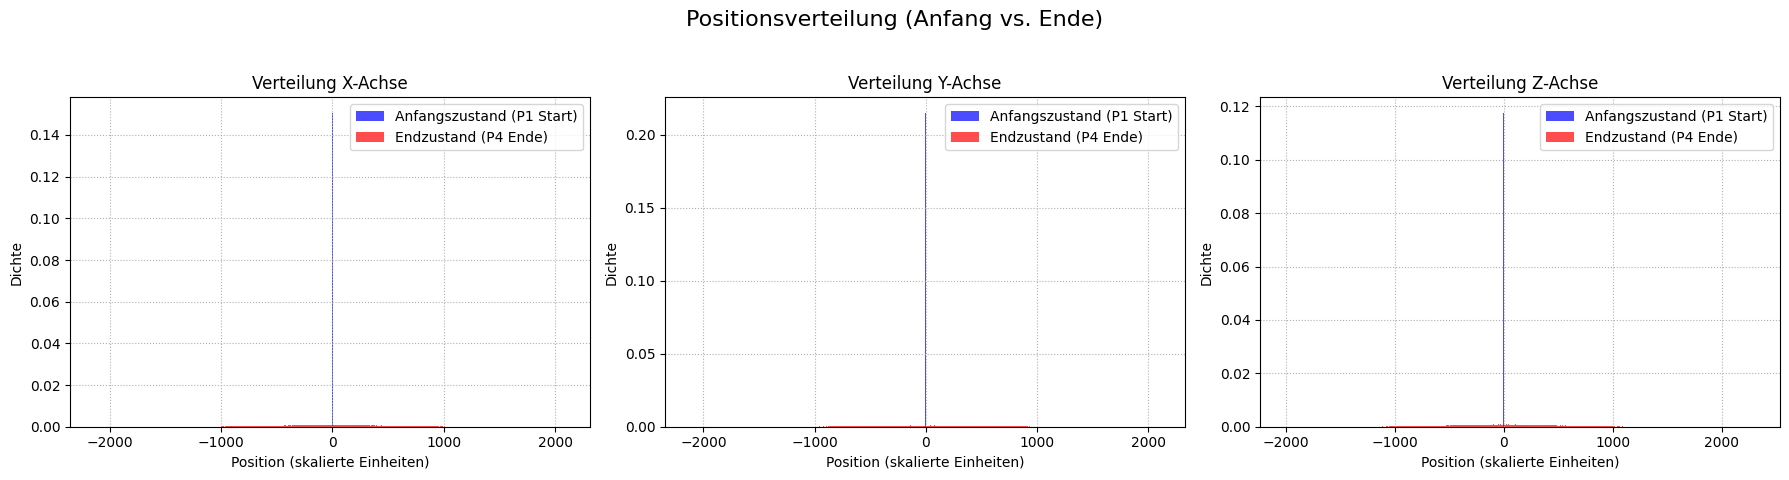


Erstelle Plot der Impulsverteilung (Anfang P1 vs. Ende P3)...


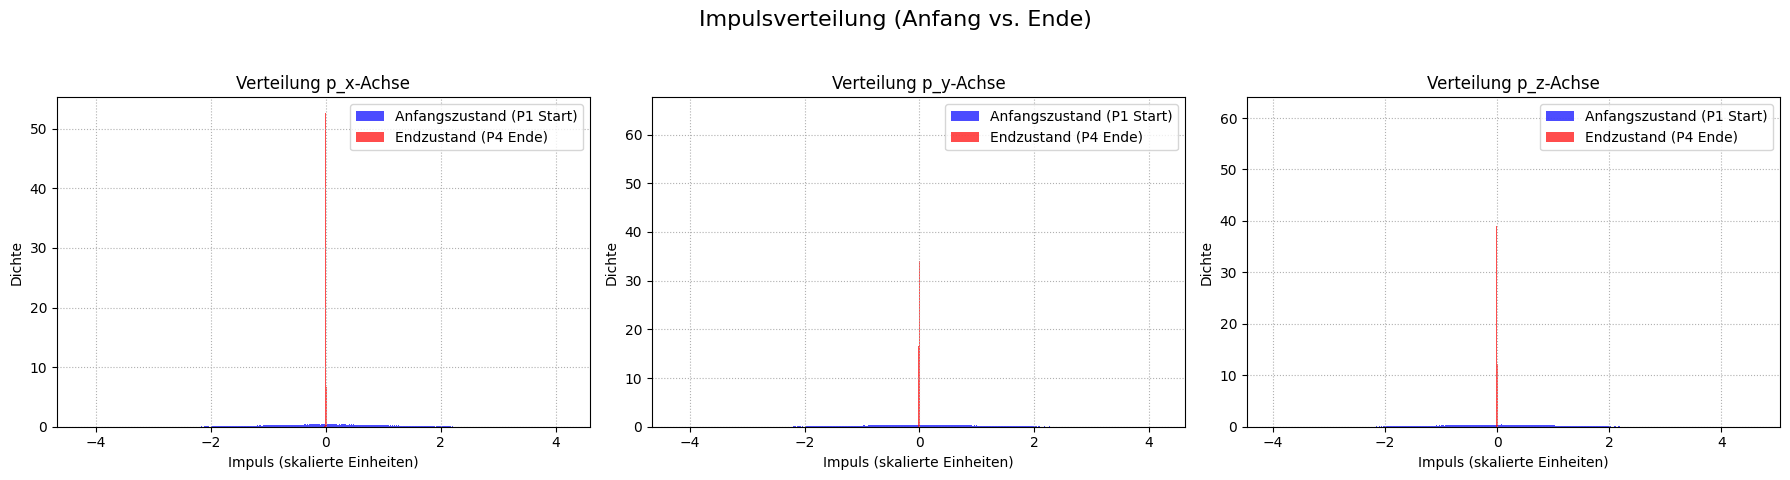


Erstelle Phasenraum-Entwicklungs-Plot (analog zu Fig. 2)...


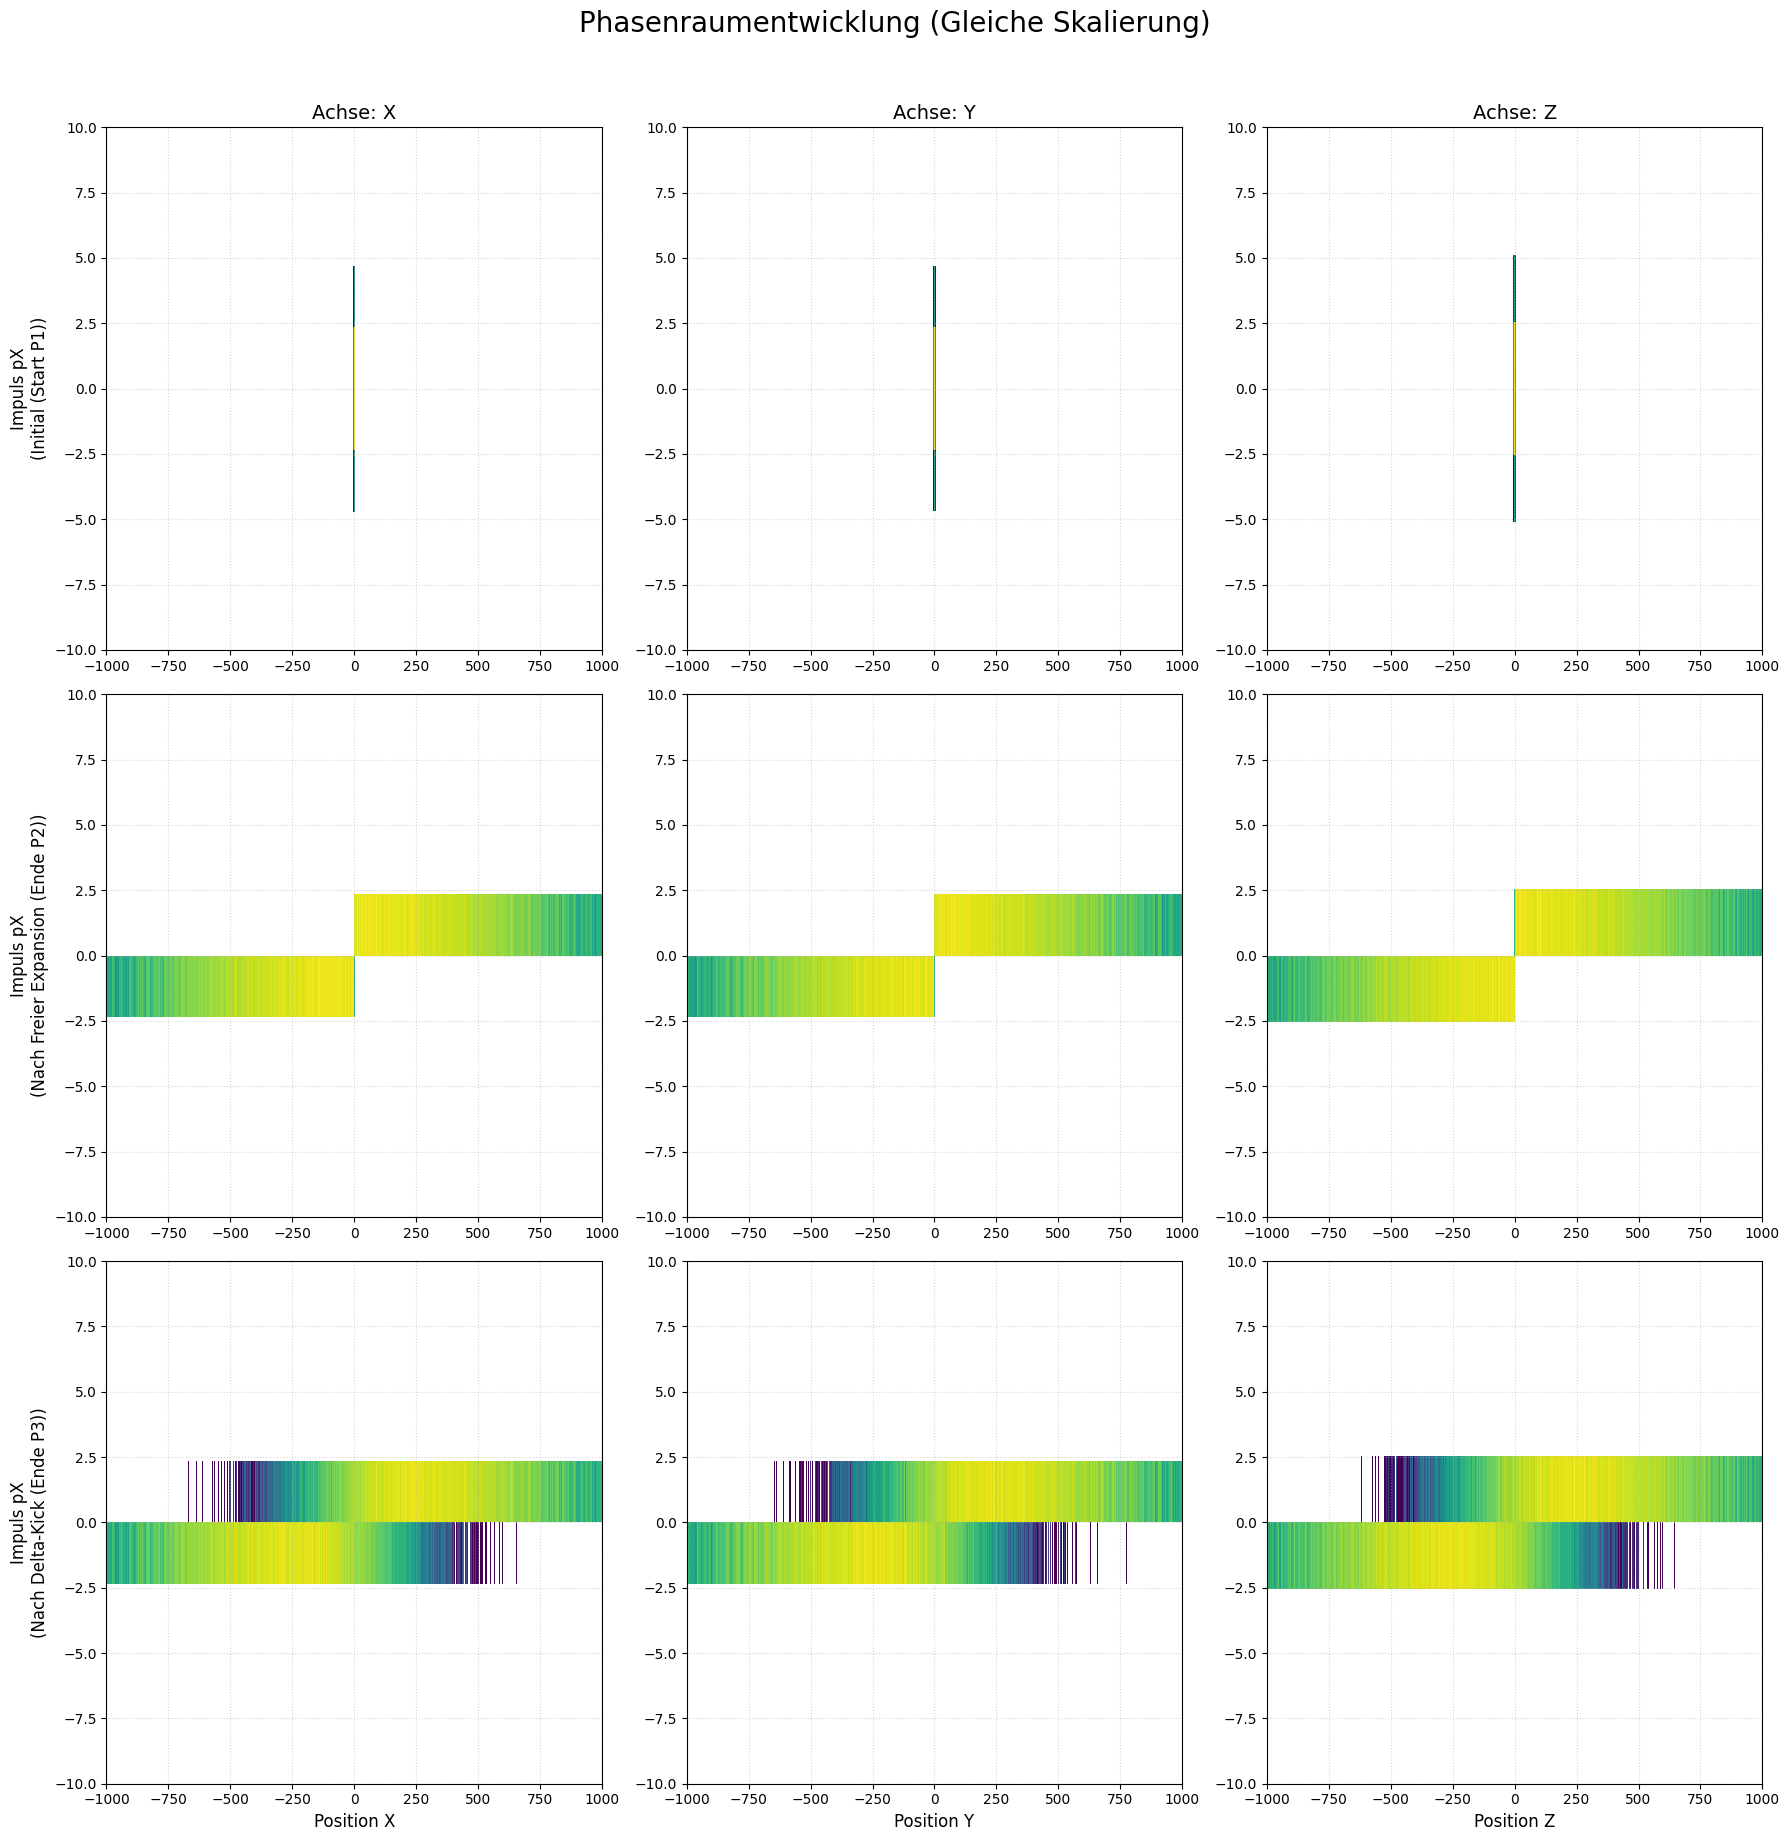

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import LogNorm
from typing import Dict
def plot_position_distribution(
    q_initial: torch.Tensor,
    q_final: torch.Tensor,
    bins: int = 1000,
    title_str: str = "Positionsverteilung (Anfang vs. Ende)"
):
    """
    Plottet die Positionsverteilungen (Histogramme) für die X-, Y- und Z-Achse
    für einen Anfangs- (q_initial) und einen Endzustand (q_final).

    Args:
        q_initial (torch.Tensor): Positionstensor [N, 3] zum Startzeitpunkt.
        q_final (torch.Tensor): Positionstensor [N, 3] zum Endzeitpunkt.
        bins (int): Anzahl der Bins für das Histogramm.
        title_str (str): Titel für den gesamten Plot.
    """

    # Daten für das Plotten auf die CPU und in NumPy konvertieren
    q_init_np = q_initial.cpu().numpy()
    q_final_np = q_final.cpu().numpy()

    # Erstelle 3 Subplots (1 Zeile, 3 Spalten)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(title_str, fontsize=16)

    # Achsen-Namen
    axis_names = ['X-Achse', 'Y-Achse', 'Z-Achse']

    for i in range(3):
        ax = axes[i]

        # Finde gemeinsame Bins, die beide Verteilungen abdecken
        min_val = min(q_init_np[:, i].min(), q_final_np[:, i].min())
        max_val = max(q_init_np[:, i].max(), q_final_np[:, i].max())
        bin_edges = np.linspace(min_val, max_val, bins + 1)

        # Plot-Histogramm für den Anfangszustand (Blau)
        ax.hist(
            q_init_np[:, i],
            bins=bin_edges,
            alpha=0.7,
            label='Anfangszustand (P1 Start)',
            color='blue',
            density=True # Normiert (damit die Flächen vergleichbar sind)
        )

        # Plot-Histogramm für den Endzustand (Rot)
        ax.hist(
            q_final_np[:, i],
            bins=bin_edges,
            alpha=0.7,
            label='Endzustand (P4 Ende)',
            color='red',
            density=True
        )

        ax.set_title(f"Verteilung {axis_names[i]}")
        ax.set_xlabel("Position (skalierte Einheiten)")
        ax.set_ylabel("Dichte")
        ax.legend()
        ax.grid(True, linestyle=':')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Platz für den Suptitle
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_momentum_distribution(
    p_initial: torch.Tensor,
    p_final: torch.Tensor,
    bins: int = 1000,
    title_str: str = "Impulsverteilung (Anfang vs. Ende)"
):
    """
    Plottet die Impulsverteilungen (Histogramme) für die X-, Y- und Z-Achse
    für einen Anfangs- (p_initial) und einen Endzustand (p_final).

    Args:
        p_initial (torch.Tensor): Impulstensor [N, 3] zum Startzeitpunkt.
        p_final (torch.Tensor): Impulstensor [N, 3] zum Endzeitpunkt.
        bins (int): Anzahl der Bins für das Histogramm.
        title_str (str): Titel für den gesamten Plot.
    """

    # Daten für das Plotten auf die CPU und in NumPy konvertieren
    p_init_np = p_initial.cpu().numpy()
    p_final_np = p_final.cpu().numpy()

    # Erstelle 3 Subplots (1 Zeile, 3 Spalten)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(title_str, fontsize=16)

    # Achsen-Namen
    axis_names = ['p_x-Achse', 'p_y-Achse', 'p_z-Achse']

    for i in range(3):
        ax = axes[i]

        # Finde gemeinsame Bins, die beide Verteilungen abdecken
        min_val = min(p_init_np[:, i].min(), p_final_np[:, i].min())
        max_val = max(p_init_np[:, i].max(), p_final_np[:, i].max())
        bin_edges = np.linspace(min_val, max_val, bins + 1)

        # Plot-Histogramm für den Anfangszustand (Blau)
        ax.hist(
            p_init_np[:, i],
            bins=bin_edges,
            alpha=0.7,
            label='Anfangszustand (P1 Start)',
            color='blue',
            density=True # Normiert
        )

        # Plot-Histogramm für den Endzustand (Rot)
        ax.hist(
            p_final_np[:, i],
            bins=bin_edges,
            alpha=0.7,
            label='Endzustand (P4 Ende)',
            color='red',
            density=True
        )

        ax.set_title(f"Verteilung {axis_names[i]}")
        ax.set_xlabel("Impuls (skalierte Einheiten)")
        ax.set_ylabel("Dichte")
        ax.legend()
        ax.grid(True, linestyle=':')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Platz für den Suptitle
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import LogNorm # Für besseren Kontrast bei 2D-Histogrammen

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import LogNorm

def plot_phase_space_evolution(
    res1: Dict,
    res2: Dict,
    res3: Dict,
    bins: int = 100
):
    """
    Plottet die Phasenraumentwicklung (p vs q) zu den drei
    entscheidenden Zeitpunkten: Initial, nach Expansion und nach Kick.
    ACHSEN HABEN JETZT GLEICHE SKALIERUNG.
    """

    # --- 1. Daten extrahieren ---
    q_init = res1['positions'][0].cpu().numpy()
    p_init = res1['momenta'][0].cpu().numpy()

    q_exp = res2['positions'][-1].cpu().numpy()
    p_exp = res2['momenta'][-1].cpu().numpy()

    q_kick = res3['positions'][-1].cpu().numpy()
    p_kick = res3['momenta'][-1].cpu().numpy()

    # --- 2. Plot-Limits bestimmen (wichtig für den Vergleich!) ---
    # Finde die globalen Min/Max-Werte für alle Phasen, für alle Achsen
    q_all = np.concatenate((q_init, q_exp, q_kick), axis=0)
    p_all = np.concatenate((p_init, p_exp, p_kick), axis=0)

    limits = []
    for i in range(3): # X, Y, Z
        # Finde den größten absoluten Wert, um die Achsen um 0 zu zentrieren
        max_abs_q = np.max(np.abs(q_all[:, i]))
        max_abs_p = np.max(np.abs(p_all[:, i]))

        # Nimm das Maximum von beiden, um die Skalierung gleich zu machen
        max_limit = max(max_abs_q, max_abs_p) * 1.1 # 10% Puffer

        limits.append([
            [-max_limit, max_limit], # q-Limits
            [-max_limit, max_limit]  # p-Limits (identisch)
        ])

    # --- 3. Plot erstellen (3x3 Gitter) ---
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle("Phasenraumentwicklung (Gleiche Skalierung)", fontsize=20, y=1.02)

    axis_names = ['X', 'Y', 'Z']
    plot_data = [
        (q_init, p_init, "Initial (Start P1)"),
        (q_exp, p_exp, "Nach Freier Expansion (Ende P2)"),
        (q_kick, p_kick, "Nach Delta-Kick (Ende P3)")
    ]

    for row, (q_data, p_data, title_suffix) in enumerate(plot_data):
        for col in range(3):
            ax = axes[row, col]

            # 2D-Histogramm plotten
            h = ax.hist2d(
                q_data[:, col],
                p_data[:, col],
                bins=bins,
                range=limits[col], # Feste, quadratische Limits
                cmap='viridis',
                norm=LogNorm()
            )

            # --- HIER IST DIE ÄNDERUNG ---
          #  ax.set_aspect('equal', adjustable='box')
            ax.set_xlim(-1000,1000)
            ax.set_ylim(-10,10)
            # -----------------------------
            # -----------------------------

            # Titel und Labels
            if row == 0:
                ax.set_title(f"Achse: {axis_names[col]}", fontsize=14)
            if col == 0:
                ax.set_ylabel(f"Impuls p{axis_names[col]}\n({title_suffix})", fontsize=12)
            if row == 2:
                ax.set_xlabel(f"Position {axis_names[col]}", fontsize=12)

            ax.grid(True, linestyle=':', alpha=0.5)

    plt.tight_layout()
    plt.show()

# --- NEU: POSITIONSVERTEILUNG PLOTTEN ---

# Holen Sie den Anfangszustand (erster Zeitschritt von Phase 1)
q_start_p1 = res1['positions'][0]

# Holen Sie den Endzustand (letzter Zeitschritt von Phase 4)
q_end_p4 = res4['positions'][-1]


import torch
from typing import Tuple






print("\nErstelle Plot der Positionsverteilung (Anfang vs. Ende)...")
plot_position_distribution(q_start_p1, q_end_p4)


# --- NEU: IMPULSVERTEILUNG PLOTTEN ---

# Holen Sie den Anfangsimpuls (erster Zeitschritt von Phase 1)
p_start_p1 = res1['momenta'][0]

# Holen Sie den Endimpuls (letzter Zeitschritt von Phase 4)
# WICHTIG: Wir nehmen den Impuls von Phase 3, direkt NACH dem Kick!
# Der Impuls ändert sich in Phase 4 (freie Expansion) nicht mehr.
p_end_p3_kick = res3['momenta'][-1]


print("\nErstelle Plot der Impulsverteilung (Anfang P1 vs. Ende P3)...")
# Wir vergleichen den Start (Phase 1) mit dem Moment direkt nach dem Kick (Ende Phase 3)
plot_momentum_distribution(p_start_p1, p_end_p3_kick)

# --- NEU: PHASENRAUM-ENTWICKLUNG PLOTTEN ---

# (Die Variablen res1, res2, res3 existieren bereits aus Ihrer Simulation)

print("\nErstelle Phasenraum-Entwicklungs-Plot (analog zu Fig. 2)...")
plot_phase_space_evolution(
    res1=simulation_results_phase1,
    res2=simulation_results_phase2,
    res3=simulation_results_phase3,
    bins=2000 # Anzahl der Bins für das Histogramm
)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import LogNorm

def plot_phase_space_snapshot(
    q_data: np.ndarray,
    p_data: np.ndarray,
    axis_limits: list,
    bins: int,
    title_suffix: str
):
    """
    Erstellt EINE Abbildung mit 3 Subplots (X, Y, Z) für den Phasenraum
    zu einem bestimmten Zeitpunkt (z.B. "Initial" oder "Nach Kick").
    """

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Phasenraum: {title_suffix}", fontsize=16)

    axis_names = ['X', 'Y', 'Z']

    for i in range(3): # Schleife über Achsen X, Y, Z
        ax = axes[i]

        # 2D-Histogramm plotten
        ax.hist2d(
            q_data[:, i],
            p_data[:, i],
            bins=bins,
            range=axis_limits[i], # Feste, quadratische Limits
            cmap='viridis',
            norm=LogNorm()
        )

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(axis_limits[i][0])
        ax.set_ylim(axis_limits[i][1])
        ax.set_title(f"Achse: {axis_names[i]}")
        ax.set_xlabel(f"Position {axis_names[i]}")
        ax.set_ylabel(f"Impuls p{axis_names[i]}")
        ax.grid(True, linestyle=':', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Erstelle Phasenraum-Snapshot-Plots (analog zu Fig. 2)...


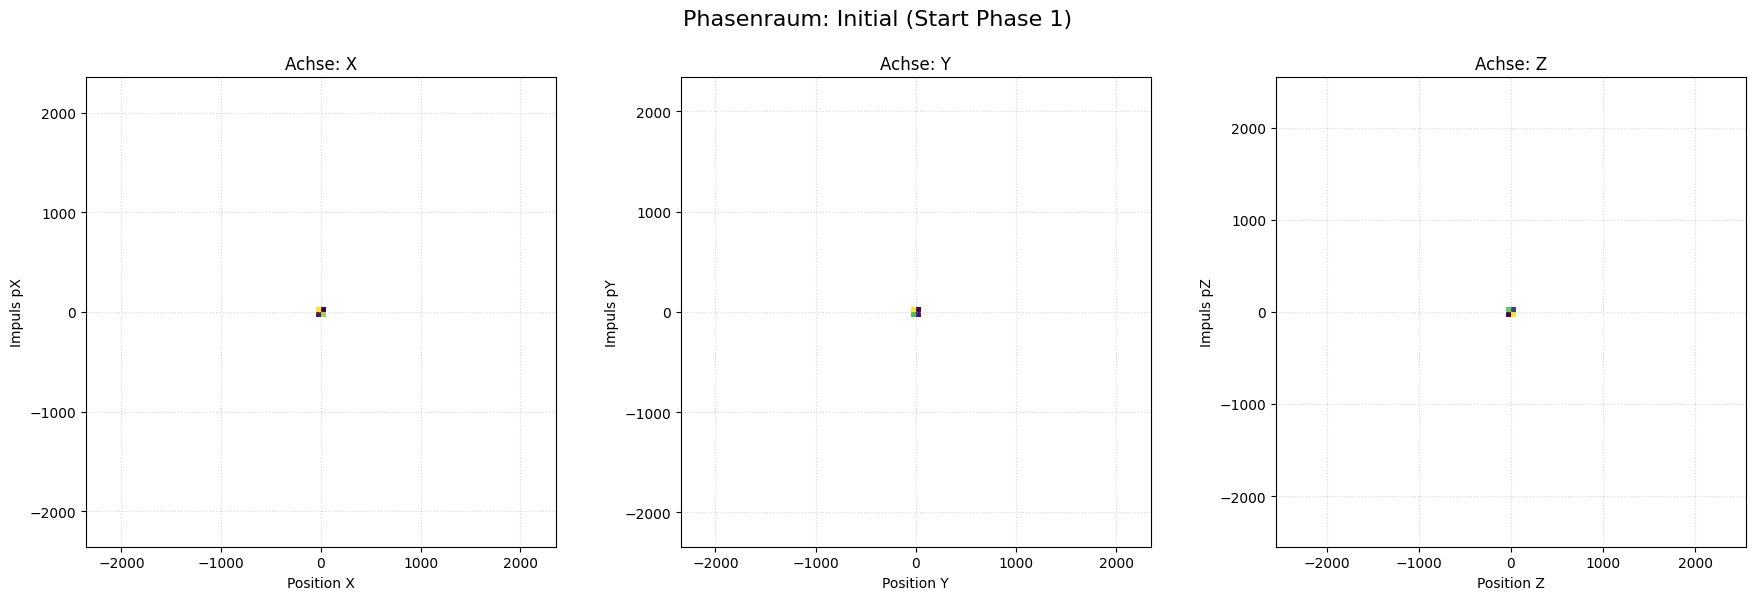

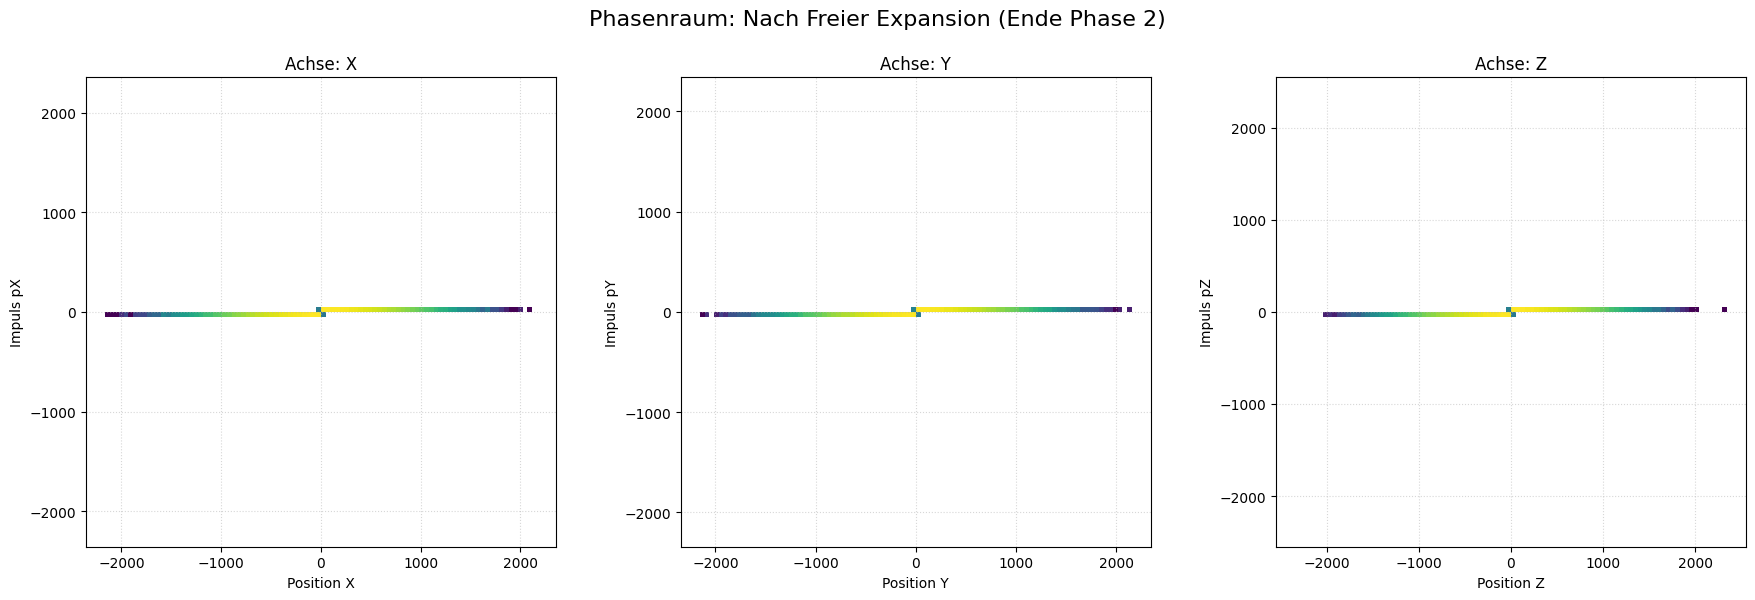

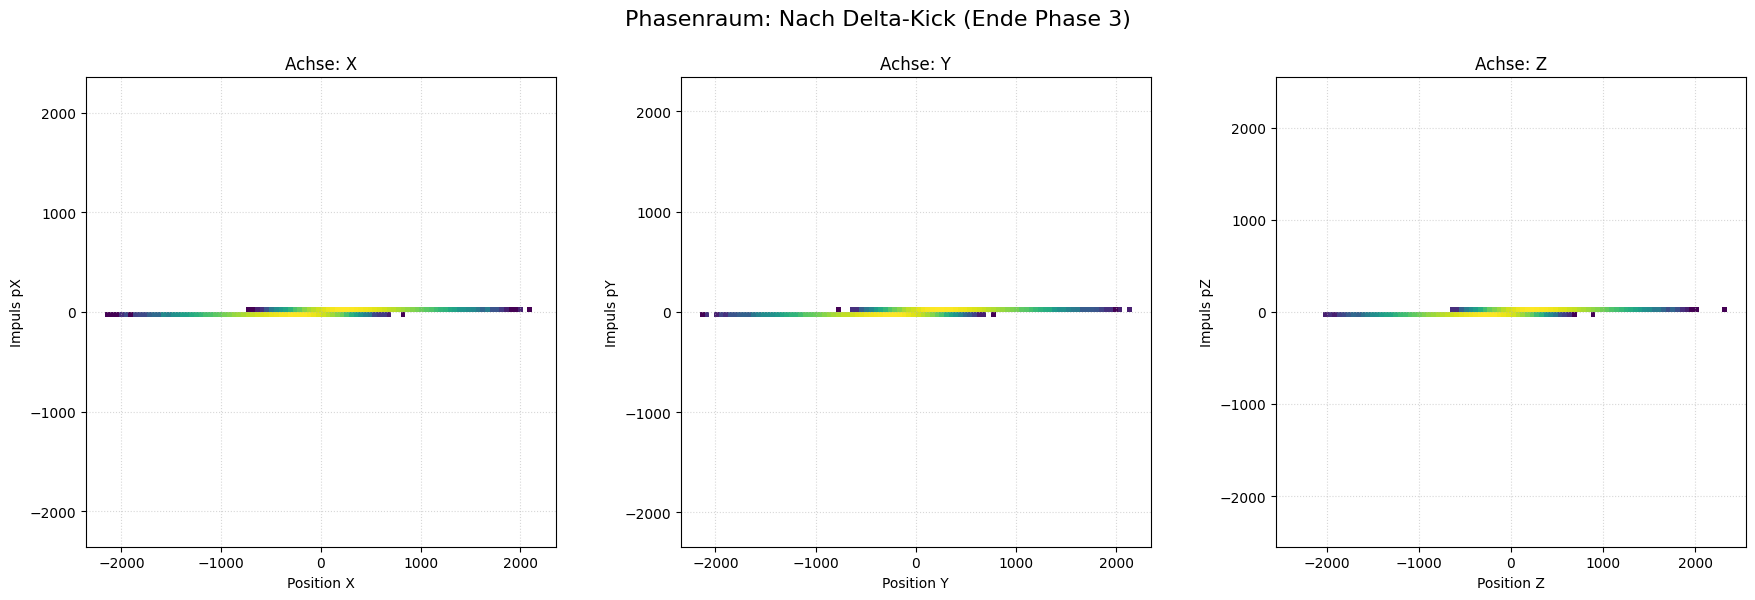

In [8]:
# --- NEU: PHASENRAUM-SNAPSHOTS PLOTTEN (3 Separate Plots) ---

# (Die Variablen res1, res2, res3 existieren bereits aus Ihrer Simulation)

print("\nErstelle Phasenraum-Snapshot-Plots (analog zu Fig. 2)...")

# --- 1. Daten extrahieren ---
q_init = res1['positions'][0].cpu().numpy()
p_init = res1['momenta'][0].cpu().numpy()

q_exp = res2['positions'][-1].cpu().numpy()
p_exp = res2['momenta'][-1].cpu().numpy()

q_kick = res3['positions'][-1].cpu().numpy()
p_kick = res3['momenta'][-1].cpu().numpy()

# --- 2. Globale Plot-Limits bestimmen (für alle 3 Plots) ---
q_all = np.concatenate((q_init, q_exp, q_kick), axis=0)
p_all = np.concatenate((p_init, p_exp, p_kick), axis=0)

global_limits = []
for i in range(3): # X, Y, Z
    max_abs_q = np.max(np.abs(q_all[:, i]))
    max_abs_p = np.max(np.abs(p_all[:, i]))
    max_limit = max(max_abs_q, max_abs_p) * 1.1 # 10% Puffer
    global_limits.append([[-max_limit, max_limit], [-max_limit, max_limit]])

bins_hist = 100

# --- 3. Plot-Funktion 3x aufrufen ---

# Plot 1: Initial
plot_phase_space_snapshot(
    q_init, p_init,
    axis_limits=global_limits,
    bins=bins_hist,
    title_suffix="Initial (Start Phase 1)"
)

# Plot 2: Nach Freier Expansion
plot_phase_space_snapshot(
    q_exp, p_exp,
    axis_limits=global_limits,
    bins=bins_hist,
    title_suffix="Nach Freier Expansion (Ende Phase 2)"
)

# Plot 3: Nach Delta-Kick
plot_phase_space_snapshot(
    q_kick, p_kick,
    axis_limits=global_limits,
    bins=bins_hist,
    title_suffix="Nach Delta-Kick (Ende Phase 3)"
)